# PHYS 481 Assignment 7: Diffusion

### Author 1 (30114124) Aki
### Author 2 (30133483) Yuwan
### Author 3 (30154399) Christian
### Author 4 (30133957) Hayden

## Introduction

This assignment analyses the diffusion of N2's density through a surface plot with both methods of random walks and explicit Euler of the Fokker-Planck equation. Then both methods and densities are compared.

## Q1

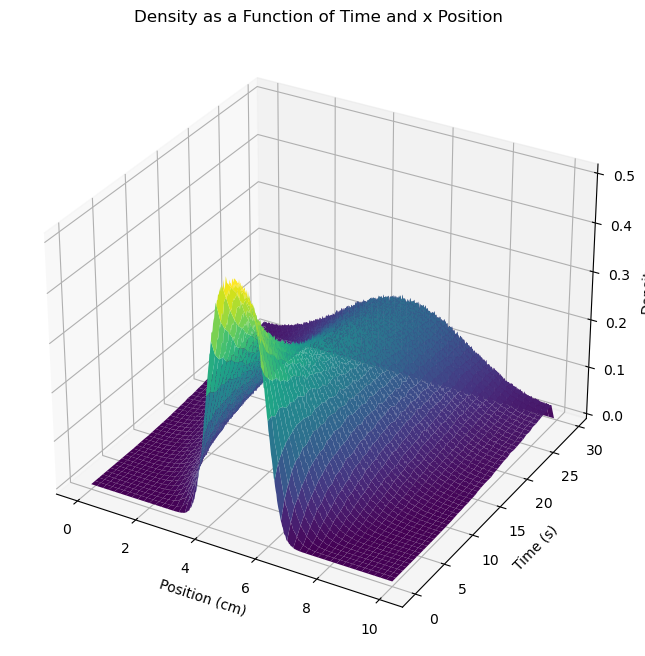

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# constants and initial conditions
length = 10  # length of the box in cm
mean_free_path = 67e-7  # mean free path in cm
average_speed = 48000  # average speed of N2 molecules in cm/s
simulation_time = 30  # total simulation time in seconds
num_steps = 50 # number of time steps to run
time_step = simulation_time / num_steps # time step for simulation in seconds
initial_num_molecules = 1000000


def gen_points():
    '''
    Simulate the random movement of particles in a one-dimensional box and calculate the density over time.

    Returns:
      numpy.ndarray: Array containing density data at different time steps.
    '''
    
    # randomly generate initial conditions
    positions = np.random.uniform(4, 6, size=initial_num_molecules)

    # create array to store generated data
    density_data = np.zeros((num_steps, length * num_steps))  

    # generate data for t = 0
    # density = True makes the histogram return a density
    hist, useless = np.histogram(positions, density = True, bins=np.linspace(0, length, length * num_steps + 1))
    density_data[0] = hist 

    for step in range(num_steps - 1):
        # move particles randomly based on average speed and mean free path 
        positions += np.random.normal(0, mean_free_path * average_speed, size=positions.shape)
        
        # deal with edges

        positions[positions < 0] += 10
        positions[positions > 10] -= 10
        
        # calculate a 2d histogram of the density for the time slice
        # density = True will calculate density for us
        # then add to the array 
        hist, useless = np.histogram(positions, density = True, bins=np.linspace(0, length, length * num_steps + 1))
        density_data[step] = hist
    return density_data


def plot_surface(density_data):
    '''
    Plot a 3D surface of density as a function of time and position.

    Parameters:
      density_data (numpy.ndarray): Array containing density data at different time steps.
    '''
    
    # create time and position arrays for plotting
    time_array = np.arange(0, simulation_time, time_step)
    position_array = np.linspace(0, length, length * num_steps)

    # create surface plot
    X, Y = np.meshgrid(position_array, time_array)
    Z = density_data

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_xlabel('Position (cm)')
    ax.set_ylabel('Time (s)')
    ax.set_zlabel('Density')

    plt.title('Density as a Function of Time and x Position')
    plt.show()

pts = gen_points()
plot_surface(pts)

## Q2

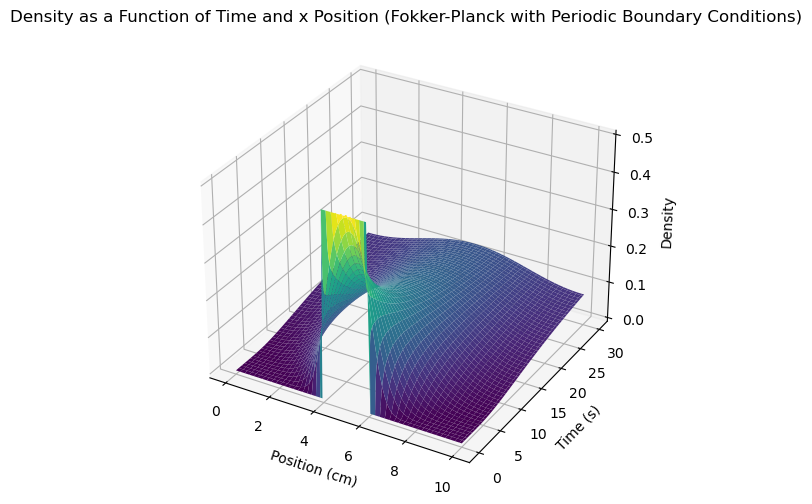

In [6]:
# constants and initial conditions
length = 10  # length of the box in cm
mean_free_path = 6.7e-6  # mean free path in cm
average_speed = 48000  # average speed of N2 molecules in cm/s
simulation_time = 30  # total simulation time in seconds
num_steps = 5000  # number of time steps
num_points = 100  # number of spatial points
tau = average_speed / mean_free_path
diffusion_coefficient = mean_free_path ** 2 / 2 * (tau)
x_points = np.linspace(0, length, num_points)  # spatial grid

# time and space step sizes
dt = simulation_time / num_steps
dx = length / (num_points - 1)

# initial conditions, a nonzero density specifically 1/2 in between 4 <= x <= 6
initial_density = np.zeros(num_points)
initial_density[np.logical_and(x_points >= 4, x_points <= 6)] = 1 / (6 - 4)  # adjusted for a constant density


def fokker_planck_step(density, diffusion_coefficient, dt, dx):
    '''
    Perform a single time step of the Fokker-Planck equation.

    Parameters:
      density (numpy.ndarray): Current density distribution.
      diffusion_coefficient (float): Diffusion coefficient.
      drift_velocity (float): Drift velocity.
      dt (float): Time step size.
      dx (float): Spatial step size.

    Returns:
      numpy.ndarray: Updated density distribution after one time step.
    '''
    
    new_density = density.copy()
    for i in range(1, len(density) - 1):
        # update with both drift and diffusion terms
        diffusion_term = diffusion_coefficient * (density[i + 1] - 2 * density[i] + density[i - 1]) / dx**2
        new_density[i] = density[i] + (diffusion_term) * dt
    
    # apply periodic boundary conditions
    new_density[0] = new_density[-2]
    new_density[-1] = new_density[1]
    
    return new_density


def gen_points_fokker_planck():
    '''
    Generate density data using the Fokker-Planck equation with periodic boundary conditions.

    Returns:
      list of numpy.ndarray: List of density distributions at different time steps.
    '''
    
    density_data = [initial_density.copy()]

    for step in range(num_steps):
        # update density using the Fokker-Planck equation
        new_density = fokker_planck_step(density_data[-1], diffusion_coefficient, dt, dx)

        # record the density for the current time step
        density_data.append(new_density)

    return density_data


def plot_surface_fokker_planck(density_data):
    '''
    Plot a 3D surface of density as a function of time and position using Fokker-Planck results.

    Parameters:
      density_data (list of numpy.ndarray): List of density distributions at different time steps.
    '''
    
    time_array = np.arange(0, simulation_time + dt, dt)

    X, Y = np.meshgrid(x_points, time_array)
    Z = np.array(density_data)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_xlabel('Position (cm)')
    ax.set_ylabel('Time (s)')
    ax.set_zlabel('Density')

    plt.title('Density as a Function of Time and x Position (Fokker-Planck with Periodic Boundary Conditions)')
    plt.show()

# generate data using Fokker-Planck equation
pts_fokker_planck = gen_points_fokker_planck()

# plot the results
plot_surface_fokker_planck(pts_fokker_planck)

## Q3

Curiously, Q1 density at time 28-30s falls back to 0.0 while Q2 density remains 0.3-0.6 around the same time. This could be a coding issue in Q1 as the density distribution would still continue beyond 30s. 

## Conclusion

Based on both surface plots, Fokker Planck depicts a more accurate representation of the diffusion of N2. The plot starts off as a rectangular shape with the particle distributions slowly smoothening out close to a flat plane. This is like Q1’s surface plots, however, it is fuzzier, and it starts off with an oval shape with its distribution not evening out properly. Curiously, Q1 density at time 28-30s falls back to 0.0 while Q2 density remains 0.3-0.6 around the same time. This could be a coding issue in Q1 as the density distribution would still continue beyond the 30s. Theoretically, both plots should be relatively similar and behave similarly.   